In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import pickle

# ============================
# Reproducibility
# ============================
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ============================
# Boyce Index
# ============================
def boyce_index(preds, pres_labels, bins=10):
    preds = np.array(preds).ravel()
    pres_labels = np.array(pres_labels).ravel()

    presence_preds = preds[pres_labels == 1]
    background_preds = preds[pres_labels == 0]

    if len(np.unique(presence_preds)) < 2:
        return 0

    bin_edges = np.linspace(min(preds), max(preds), bins + 1)
    obs_freq, _ = np.histogram(presence_preds, bins=bin_edges)
    exp_freq, _ = np.histogram(background_preds, bins=bin_edges)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = obs_freq / exp_freq
        valid = ~np.isnan(ratio) & ~np.isinf(ratio) & (exp_freq > 0)
        if np.sum(valid) < 2:
            return 0
        mid_points = (bin_edges[:-1] + bin_edges[1:]) / 2
        return np.corrcoef(mid_points[valid], ratio[valid])[0, 1]

# ============================
# Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# Custom deepmaxent_loss
# ============================
def deepmaxent_loss(logits, targets):
    probs = torch.sigmoid(logits)
    eps = 1e-8
    loss = - (targets * torch.log(probs + eps) +
              (1 - targets) * torch.log(1 - probs + eps))
    return loss.mean()

# ============================
# Training Function
# ============================
def train_model(species,loss_fn, loss_name, train_loader, test_loader, input_dim, metric="roc", num_epochs=1000, patience=15, lr=1e-3, seed=42):
    set_seed(seed)
    g = torch.Generator()
    g.manual_seed(seed)

    model = DeepMaxEntModel(input_dim=input_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_score = -1e9
    lowest_loss = 1e9
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            logits = model(batch_X)
            loss = loss_fn(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # Evaluate
        model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                probs = model.predict_proba(batch_X)
                all_probs.append(probs.cpu())
                all_labels.append(batch_y.cpu())

        y_true = torch.cat(all_labels).numpy().ravel()
        y_scores = torch.cat(all_probs).numpy().ravel()

        if metric == "roc":
            try:
                score = roc_auc_score(y_true, y_scores)
            except ValueError:
                score = 0.0
        elif metric == "boyce":
            score = boyce_index(y_scores, y_true)
        else:
            raise ValueError("Unknown metric")

        print(f"[{loss_name} - {metric}] Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, {metric.upper()}: {score:.4f}")

        if avg_loss < lowest_loss:
            best_score = score
            lowest_loss = avg_loss
            torch.save(model.state_dict(), f"{species}_{loss_name}_{metric}_best_model.pth")    
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping ({loss_name} - {metric}) at epoch {epoch+1}. Best {metric.upper()}: {best_score:.4f}")
                break

    return model, best_score

# ============================
# Dataset Runner
# ============================
def run_experiments(dataset_name, filepath, seed=42):
    print(f"\n===== Running Experiments for {dataset_name} =====")
    set_seed(seed)

    # Load dataset
    df = pd.read_csv(filepath)
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

    # Get train/test indices from full DataFrame
    train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=seed)
    with open(f"{dataset_name}_split.pkl", "wb") as f:
        pickle.dump({"train_idx": train_idx.tolist(), "test_idx": test_idx.tolist()}, f)

    # Train/test split
    X_train_df = df.loc[train_idx].drop(columns=['type', 'label'])
    y_train_df = df.loc[train_idx, 'label']
    X_test_df  = df.loc[test_idx].drop(columns=['type', 'label'])
    y_test_df  = df.loc[test_idx, 'label']

    # Scale environmental variables
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    scaler = StandardScaler()
    X_train_df[env_vars] = scaler.fit_transform(X_train_df[env_vars])
    X_test_df[env_vars]  = scaler.transform(X_test_df[env_vars])

    # Save the scaler
    with open(f'{dataset_name}_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # Convert to torch
    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    X_test  = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_df.values, dtype=torch.float32).unsqueeze(1)
    y_test  = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)

    g = torch.Generator()
    g.manual_seed(seed)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset  = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, generator=g)

    input_dim = X_train.shape[1]
    bce_loss = nn.BCEWithLogitsLoss()

    # Run 4 experiments
    results = {}
    results["BCE_Boyce"] = train_model(dataset_name, bce_loss, "BCEWithLogitsLoss", train_loader, test_loader, input_dim, metric="boyce", seed=seed)
    results["Deep_Boyce"] = train_model(dataset_name, deepmaxent_loss, "deepmaxent_loss", train_loader, test_loader, input_dim, metric="boyce", seed=seed)
    results["BCE_ROC"] = train_model(dataset_name, bce_loss, "BCEWithLogitsLoss", train_loader, test_loader, input_dim, metric="roc", seed=seed)
    results["Deep_ROC"] = train_model(dataset_name, deepmaxent_loss, "deepmaxent_loss", train_loader, test_loader, input_dim, metric="roc", seed=seed)

    print(f"\n===== {dataset_name} Results =====")
    for name, (_, score) in results.items():
        print(f"{name}: {score:.4f}")

    return results



# ============================
# Run All Species
# ============================
# species_datasets = {
#     # "bat": "bat_final_data_preprocessed.csv",
#     "brown_hare": "brown_hare_final_data_preprocessed.csv",
#     "dormice": "dormice_final_data_preprocessed.csv",
#     "hedgehog": "hedgehog_final_data_preprocessed.csv",
#     "red_squirrel": "red_squirrel_final_data_preprocessed.csv",
# }
# 
# all_results = {}
# for species, filepath in species_datasets.items():
#     all_results[species] = run_experiments(species, filepath, seed=42)



/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71741/2911569535.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


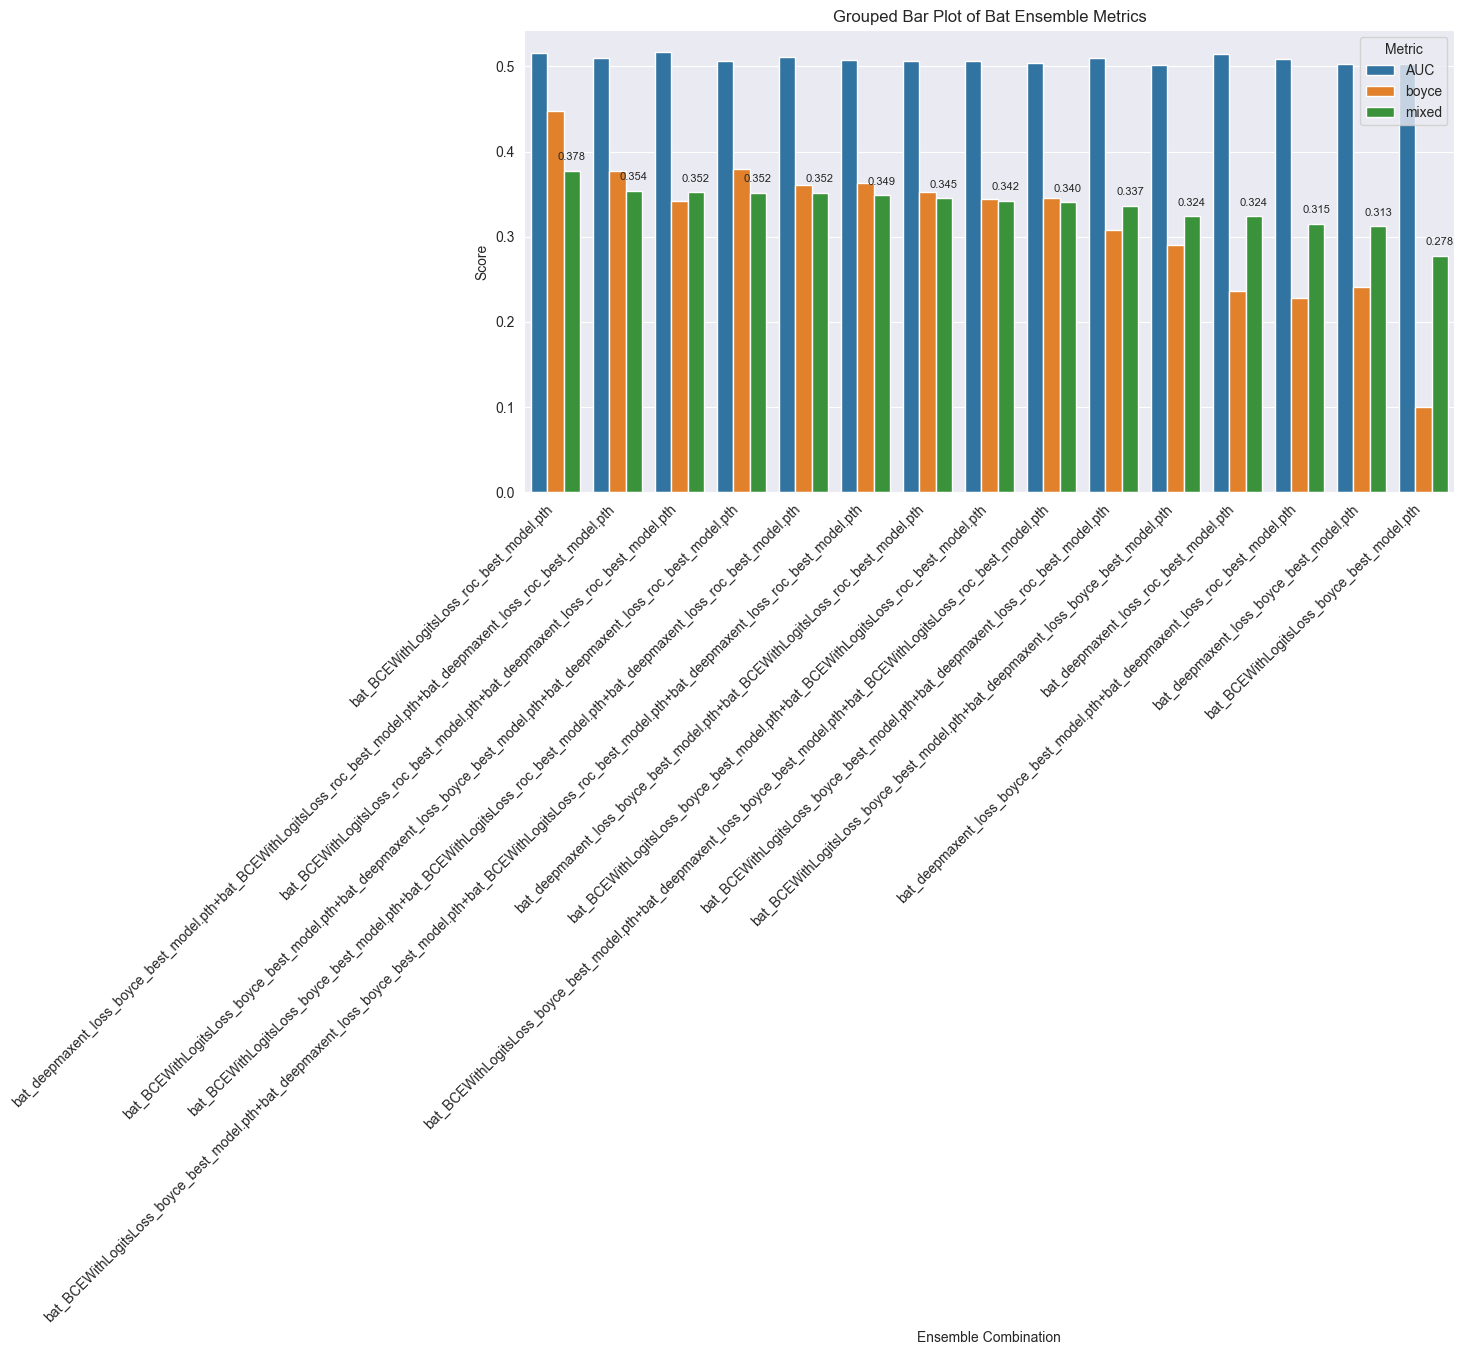

In [35]:
from itertools import chain, combinations
import numpy as np

bat_models = [ "bat_BCEWithLogitsLoss_boyce_best_model.pth", "bat_deepmaxent_loss_boyce_best_model.pth", "bat_BCEWithLogitsLoss_roc_best_model.pth", "bat_deepmaxent_loss_roc_best_model.pth" ]

# Function to get the power set of a list
def powerset(iterable):
    "powerset([1,2,3]) --> [1] [2] [3] [1,2] [1,3] [2,3] [1,2,3]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# Evaluate an ensemble of models (average probabilities)
def evaluate_ensemble(models_list, species):
    """
    models_list: list of paths to saved model .pth files
    Returns: dict with roc, boyce, mixed
    """
    # Load dataset + scaler + test split (same as evaluate_model)
    df = pd.read_csv(f"{species}_final_data_preprocessed.csv")
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
    
    # Load split indices
    with open(f"{species}_split.pkl", "rb") as f:
        split_data = pickle.load(f)
    test_idx = split_data["test_idx"]
    
    # Load scaler
    scaler = pickle.load(open(f"{species}_scaler.pkl", "rb"))
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    
    # Prepare test set
    X_df = df.drop(columns=['type','label'])
    X_df[env_vars] = scaler.transform(X_df[env_vars])
    X_test_df = X_df.loc[test_idx]
    y_test_df = df.loc[test_idx, 'label']
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)
    
    # Store predictions from all models
    all_probs = []
    input_dim = X_test_tensor.shape[1]
    
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_test_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
    # Average probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    y_true = y_test_tensor.cpu().numpy().ravel()
    
    # Metrics
    try:
        roc = roc_auc_score(y_true, ensemble_probs)
    except ValueError:
        roc = 0.0
    boyce = boyce_index(ensemble_probs, y_true)
    roc_normalized = (roc - 0.5) / 0.5
    boyce_normalized = (boyce + 1) / 2
    mixed = (roc_normalized + boyce_normalized)/2
    
    return {"AUC": roc, "boyce": boyce, "mixed": mixed}


results = {}

for subset in powerset(bat_models):
    # Ensemble name = full filenames joined by '+'
    subset_name = "+".join(subset)
    metrics = evaluate_ensemble(list(subset), species="bat")
    results[subset_name] = metrics

# Convert to DataFrame and sort by mixed score
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("mixed", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for plotting
plot_df = results_df.reset_index().rename(columns={"index":"Ensemble"}).sort_values("mixed", ascending=False)
plot_df_melted = plot_df.melt(id_vars="Ensemble", var_name="Metric", value_name="Score")

# -----------------------------
# Grouped bar plot
# -----------------------------
plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df_melted, x="Ensemble", y="Score", hue="Metric")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ensemble Combination")
plt.ylabel("Score")
plt.title("Grouped Bar Plot of Bat Ensemble Metrics")
plt.legend(title="Metric")
plt.tight_layout()

# -----------------------------
# Annotate only the Mixed bars
# -----------------------------
# The hue order in seaborn is usually alphabetical unless specified
# We'll get the unique metrics in the order Seaborn used
hue_order = sorted(plot_df_melted['Metric'].unique())
num_hues = len(hue_order)
num_ensembles = plot_df.shape[0]
total_width = 0.8
bar_width = total_width / num_hues

# Loop over each ensemble
for i in range(num_ensembles):
    x = i  # center of the group
    # Find mixed height
    mixed_height = plot_df_melted[
        (plot_df_melted['Ensemble'] == plot_df['Ensemble'].iloc[i]) & 
        (plot_df_melted['Metric'] == 'mixed')
    ]['Score'].values[0]
    # Compute x-position of the mixed bar (last bar in group)
    mixed_x = x - total_width/2 + bar_width*2 + bar_width/2
    ax.text(mixed_x, mixed_height + 0.01, f"{mixed_height:.3f}", ha='center', va='bottom', fontsize=8)

plt.show()



Loading and preprocessing data...
Data processing complete. Found 32 features.
Successfully loaded trained model from 'bat_BCEWithLogitsLoss_roc_best_model.pth'.


  0%|          | 0/200 [00:00<?, ?it/s]


--- Top 15 Most Important Features ---
                           feature  importance
0                              LST   26.230698
1    Land_cover_Improved grassland    3.722888
2                        near_road    3.720795
3              Land_cover_Suburban    2.802761
4                              BSI    2.558069
5                            MNDWI    1.966280
6                             SAVI    1.497580
7                             NDSI    1.486136
8   Land_cover_Coniferous woodland    1.381221
9                             NDWI    0.946511
10                            NDVI    0.847492
11                              UI    0.257068
12              Land_cover_Heather    0.256827
13               Land_cover_Arable    0.181823
14                            NDBI    0.140966


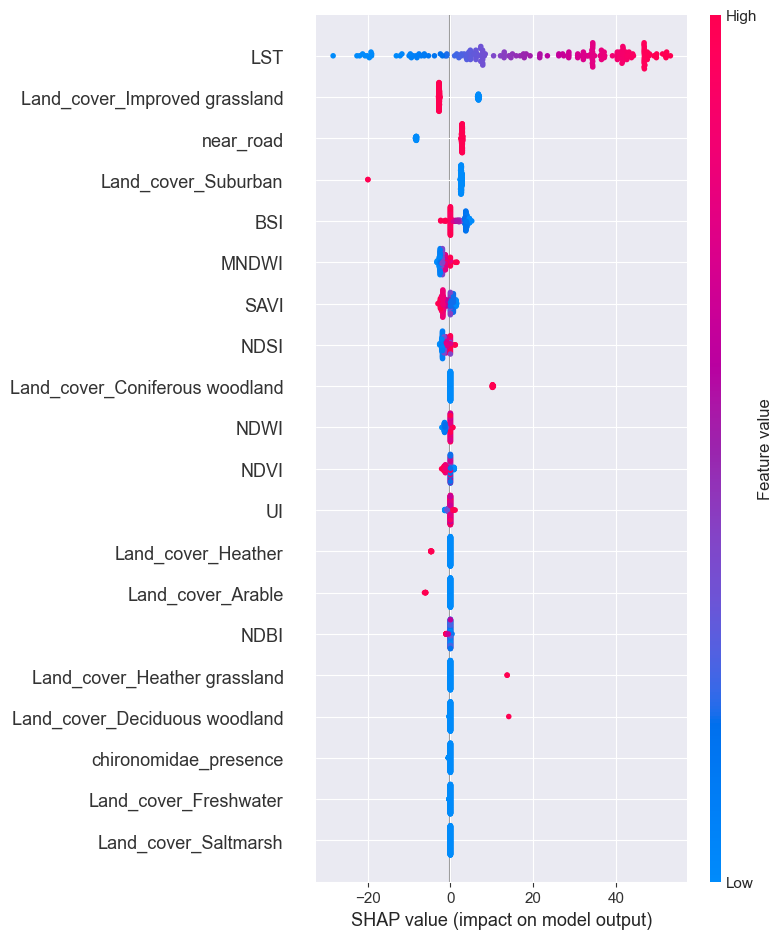

In [40]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ============================
# 1. PyTorch Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    """Residual MLP for Species Distribution Modeling"""
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)  # raw logits

# ============================
# 2. Data Loading and Preprocessing
# ============================
print("Loading and preprocessing data...")
df = pd.read_csv("bat_final_data_preprocessed.csv")

if 'type' in df.columns:
    df['presence'] = df['type'].map({'presence': 1, 'background': 0}).astype(int)
    df = df.drop(columns=['type'])

TARGET_COLUMN = 'presence'

# Convert boolean columns to integer
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

# Separate features and target
features_df = df.drop(columns=[TARGET_COLUMN])
target_series = df[TARGET_COLUMN]

# One-hot encode categorical variables
features_df_encoded = pd.get_dummies(features_df, drop_first=True)
final_feature_names = features_df_encoded.columns.tolist()

X = features_df_encoded.values
y = target_series.values

print(f"Data processing complete. Found {X.shape[1]} features.")

# ============================
# 3. Load Trained Model
# ============================
MODEL_PATH = "bat_BCEWithLogitsLoss_roc_best_model.pth"
input_dim = X.shape[1]
pytorch_model = DeepMaxEntModel(input_dim=input_dim)

try:
    pytorch_model.load_state_dict(torch.load(MODEL_PATH))
    pytorch_model.eval()
    print(f"Successfully loaded trained model from '{MODEL_PATH}'.")

    # ============================
    # 4. Define prediction function for KernelExplainer
    # ============================
    def model_predict(X_input):
        """Return raw logits as numpy array"""
        with torch.no_grad():
            return pytorch_model.forward(torch.FloatTensor(X_input)).numpy()

    # Use a small background sample (KernelExplainer is slow)
    background = X[np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(model_predict, background)

    # Compute SHAP values for a subset to save time
    subset = X[:200]  # can adjust based on memory
    shap_values = explainer.shap_values(subset)
    shap_values_array = np.array(shap_values)
    shap_values_array = np.squeeze(shap_values_array)  # shape: (n_samples, n_features)

    # Mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

    importance_df = pd.DataFrame({
        'feature': final_feature_names,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    print("\n--- Top 15 Most Important Features ---")
    print(importance_df.head(15))

    # ============================
    # 5. Barplot of Feature Importance
    # ============================
    # plt.figure(figsize=(12, 10))
    # sns.barplot(
    #     x='importance',
    #     y='feature',
    #     data=importance_df.head(20),
    #     palette='viridis'
    # )
    # plt.xlabel('Mean |SHAP Value|', fontsize=12)
    # plt.ylabel('Feature', fontsize=12)
    # plt.title('Feature Importance for Bat', fontsize=16)
    # plt.grid(axis='x', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.show()

    # ============================
    # 6. SHAP Summary Plot (magnitude + direction)
    # ============================
    X_df = pd.DataFrame(subset, columns=final_feature_names)
    top_features = importance_df['feature'].head(20).tolist()
    X_top = X_df[top_features]
    shap_values_top = shap_values_array[:, [final_feature_names.index(f) for f in top_features]]
    shap.summary_plot(
        shap_values_top,
        X_top,
        plot_type="dot",
        max_display=20
    )
except FileNotFoundError:
    print(f"\n--- ERROR --- Model file not found at '{MODEL_PATH}'.")
except RuntimeError as e:
    print(f"\n--- ERROR --- Could not load the model: {e}")


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71741/2227338569.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


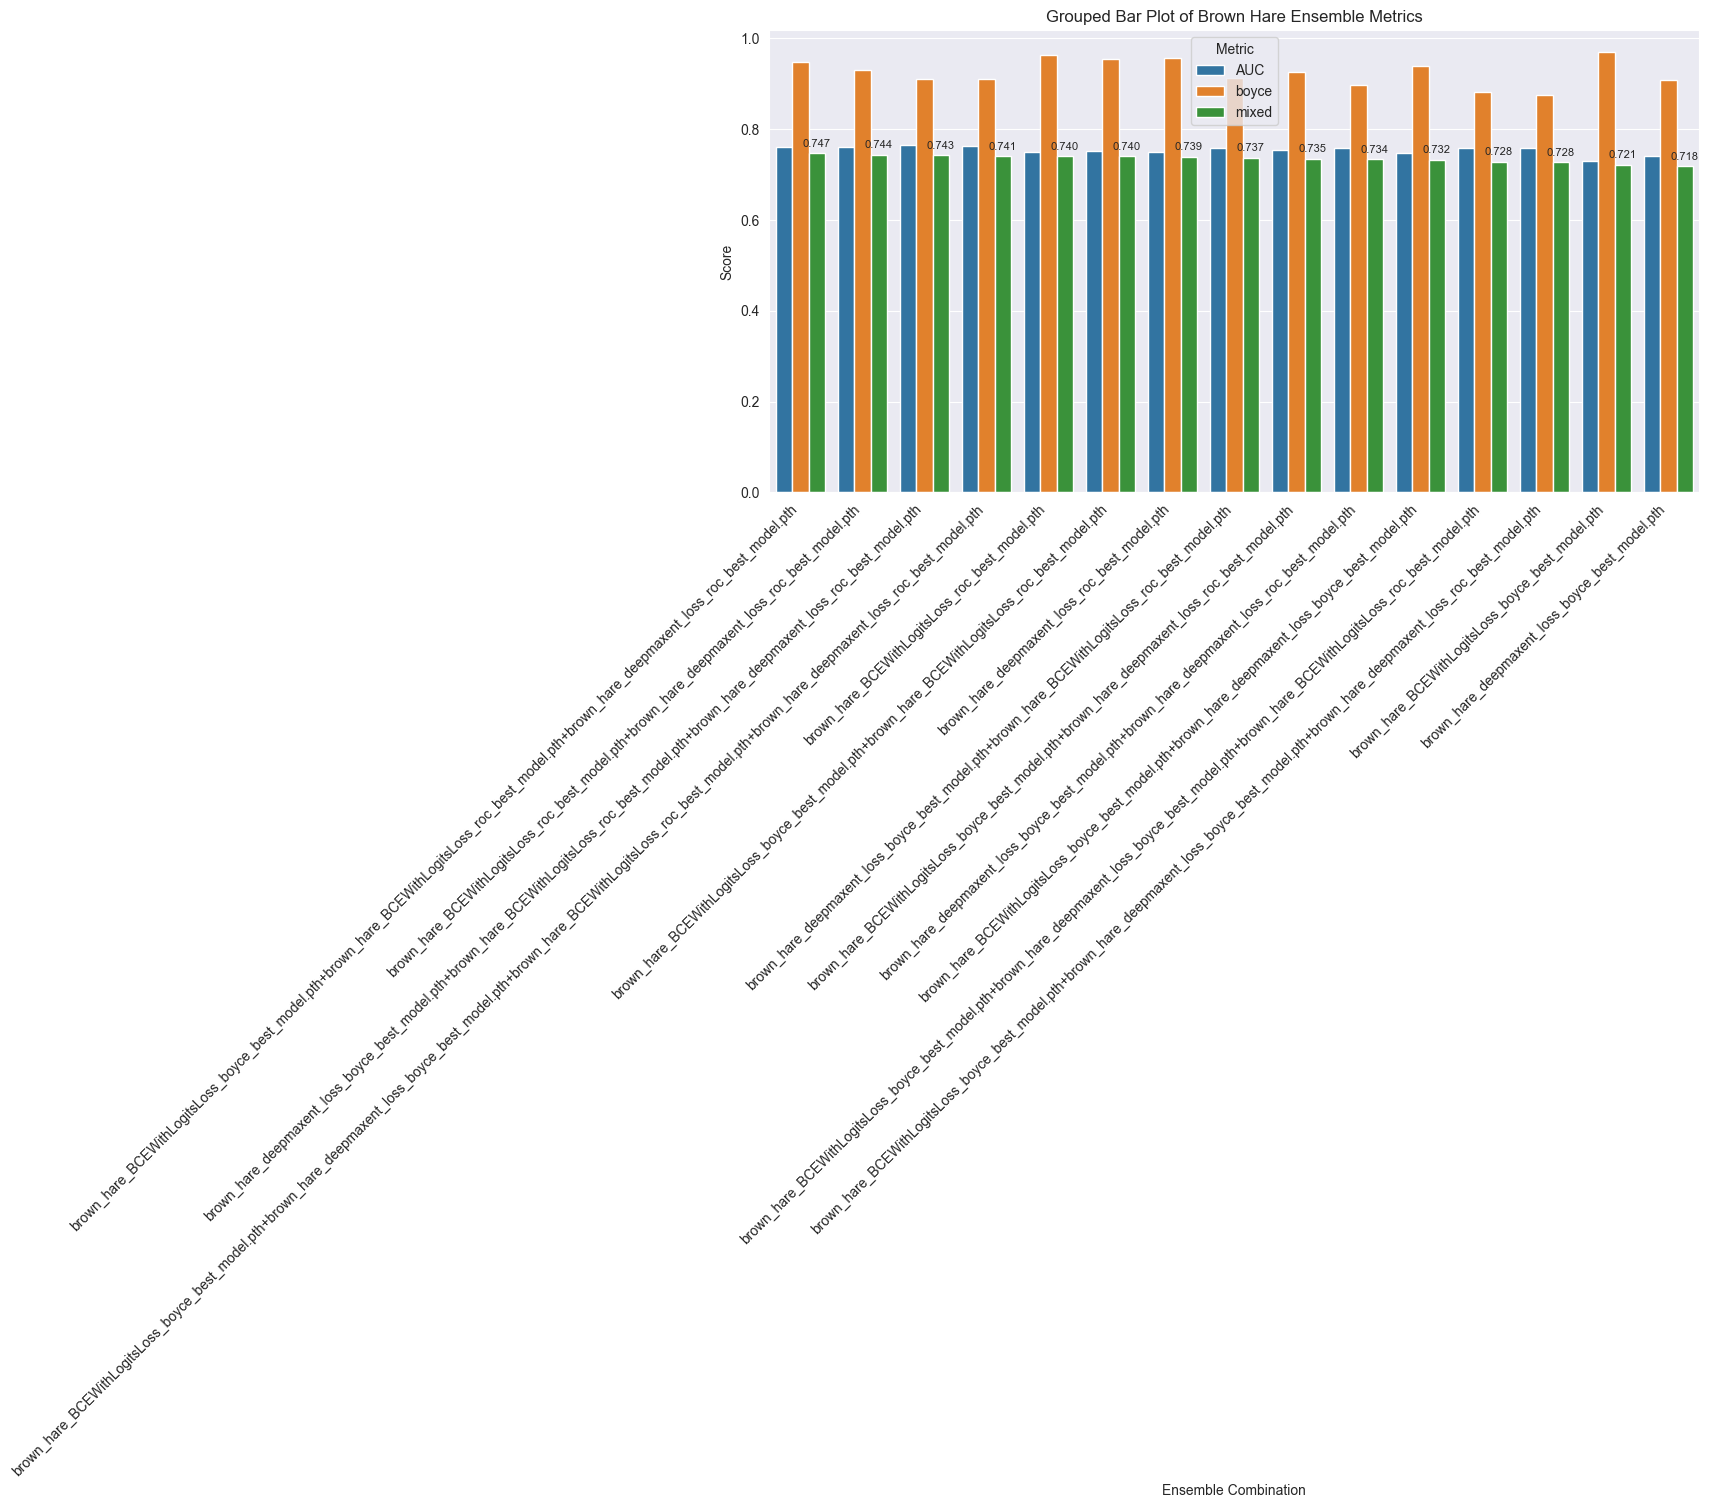

In [36]:
from itertools import chain, combinations
import numpy as np

brown_hare_models = [ "brown_hare_BCEWithLogitsLoss_boyce_best_model.pth", "brown_hare_deepmaxent_loss_boyce_best_model.pth", "brown_hare_BCEWithLogitsLoss_roc_best_model.pth", "brown_hare_deepmaxent_loss_roc_best_model.pth" ]

# Function to get the power set of a list
def powerset(iterable):
    "powerset([1,2,3]) --> [1] [2] [3] [1,2] [1,3] [2,3] [1,2,3]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# Evaluate an ensemble of models (average probabilities)
def evaluate_ensemble(models_list, species):
    """
    models_list: list of paths to saved model .pth files
    Returns: dict with roc, boyce, mixed
    """
    # Load dataset + scaler + test split (same as evaluate_model)
    df = pd.read_csv(f"{species}_final_data_preprocessed.csv")
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
    
    # Load split indices
    with open(f"{species}_split.pkl", "rb") as f:
        split_data = pickle.load(f)
    test_idx = split_data["test_idx"]
    
    # Load scaler
    scaler = pickle.load(open(f"{species}_scaler.pkl", "rb"))
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    
    # Prepare test set
    X_df = df.drop(columns=['type','label'])
    X_df[env_vars] = scaler.transform(X_df[env_vars])
    X_test_df = X_df.loc[test_idx]
    y_test_df = df.loc[test_idx, 'label']
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)
    
    # Store predictions from all models
    all_probs = []
    input_dim = X_test_tensor.shape[1]
    
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_test_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
    # Average probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    y_true = y_test_tensor.cpu().numpy().ravel()
    
    # Metrics
    try:
        roc = roc_auc_score(y_true, ensemble_probs)
    except ValueError:
        roc = 0.0
    boyce = boyce_index(ensemble_probs, y_true)
    roc_normalized = (roc - 0.5) / 0.5
    boyce_normalized = (boyce + 1) / 2
    mixed = (roc_normalized + boyce_normalized)/2
    
    return {"AUC": roc, "boyce": boyce, "mixed": mixed}


results = {}

for subset in powerset(brown_hare_models):
    # Ensemble name = full filenames joined by '+'
    subset_name = "+".join(subset)
    metrics = evaluate_ensemble(list(subset), species="brown_hare")
    results[subset_name] = metrics

# Convert to DataFrame and sort by mixed score
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("mixed", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for plotting
plot_df = results_df.reset_index().rename(columns={"index":"Ensemble"}).sort_values("mixed", ascending=False)
plot_df_melted = plot_df.melt(id_vars="Ensemble", var_name="Metric", value_name="Score")

# -----------------------------
# Grouped bar plot
# -----------------------------
plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df_melted, x="Ensemble", y="Score", hue="Metric")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ensemble Combination")
plt.ylabel("Score")
plt.title("Grouped Bar Plot of Brown Hare Ensemble Metrics")
plt.legend(title="Metric")
plt.tight_layout()

# -----------------------------
# Annotate only the Mixed bars
# -----------------------------
# The hue order in seaborn is usually alphabetical unless specified
# We'll get the unique metrics in the order Seaborn used
hue_order = sorted(plot_df_melted['Metric'].unique())
num_hues = len(hue_order)
num_ensembles = plot_df.shape[0]
total_width = 0.8
bar_width = total_width / num_hues

# Loop over each ensemble
for i in range(num_ensembles):
    x = i  # center of the group
    # Find mixed height
    mixed_height = plot_df_melted[
        (plot_df_melted['Ensemble'] == plot_df['Ensemble'].iloc[i]) & 
        (plot_df_melted['Metric'] == 'mixed')
    ]['Score'].values[0]
    # Compute x-position of the mixed bar (last bar in group)
    mixed_x = x - total_width/2 + bar_width*2 + bar_width/2
    ax.text(mixed_x, mixed_height + 0.01, f"{mixed_height:.3f}", ha='center', va='bottom', fontsize=8)

plt.show()



Loading and preprocessing data...
Data processing complete. Found 31 features.


  0%|          | 0/200 [00:00<?, ?it/s]


--- Top 15 Most Important Features ---
                           feature  importance
0                              LST   12.005652
1                Land_cover_Arable    4.147225
2    Land_cover_Improved grassland    4.082927
3                             NDWI    2.015638
4                              BSI    1.955414
5                             SAVI    1.848509
6                             NDSI    1.733333
7                            MNDWI    1.658242
8                             NDVI    1.254799
9              Land_cover_Suburban    0.825088
10              Land_cover_Heather    0.173523
11                              UI    0.110906
12                            NDBI    0.082989
13  Land_cover_Coniferous woodland    0.066906
14                Land_cover_Urban    0.039001


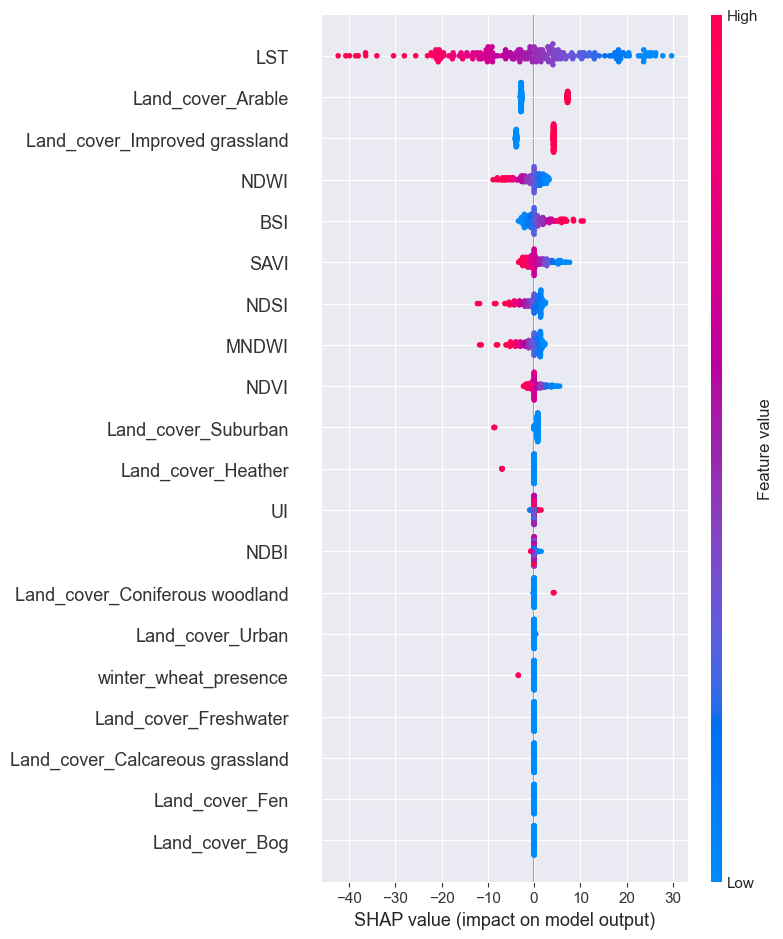

In [45]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ============================
# 1. PyTorch Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    """Residual MLP for Species Distribution Modeling"""
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)  # raw logits

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# 2. Data Loading and Preprocessing
# ============================
print("Loading and preprocessing data...")
df = pd.read_csv("brown_hare_final_data_preprocessed.csv")

# --- Preprocessing: map 'type' to binary if present
if 'type' in df.columns:
    df['presence'] = df['type'].map({'presence': 1, 'background': 0}).astype(int)
    df = df.drop(columns=['type'])

TARGET_COLUMN = 'presence'

# Convert boolean columns to integer
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

# Separate features and target
features_df = df.drop(columns=[TARGET_COLUMN])
target_series = df[TARGET_COLUMN]

X = features_df.values
feature_names = features_df.columns.tolist()
input_dim = X.shape[1]

print(f"Data processing complete. Found {input_dim} features.")

# ============================
# 3. Define Ensemble
# ============================
models_list = [
    "brown_hare_BCEWithLogitsLoss_boyce_best_model.pth",
    "brown_hare_BCEWithLogitsLoss_roc_best_model.pth",
    "brown_hare_deepmaxent_loss_roc_best_model.pth"
]

def ensemble_predict(X_input):
    """Return average raw logits across all models"""
    X_tensor = torch.tensor(X_input, dtype=torch.float32)
    all_logits = []
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            logits = model.forward(X_tensor).cpu().numpy().ravel()
            all_logits.append(logits)
    return np.mean(all_logits, axis=0)

# ============================
# 4. SHAP KernelExplainer
# ============================
background = X[np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)]
explainer = shap.KernelExplainer(ensemble_predict, background)

subset = X[:200]  # subset for speed
shap_values = explainer.shap_values(subset)
shap_values_array = np.array(shap_values)
shap_values_array = np.squeeze(shap_values_array)  # shape: (n_samples, n_features)

# ============================
# 5. Mean Absolute SHAP / Feature Importance
# ============================
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Most Important Features ---")
print(importance_df.head(15))

# ============================
# 6. Optional Barplot
# ============================
# Uncomment to visualize top 20 features
# plt.figure(figsize=(12, 10))
# sns.barplot(
#     x='importance',
#     y='feature',
#     data=importance_df.head(20),
#     palette='viridis'
# )
# plt.xlabel('Mean |SHAP Value|', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.title('Ensemble Feature Importance (KernelExplainer)', fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# ============================
# 7. SHAP Summary Plot
# ============================
subset_df = pd.DataFrame(subset, columns=feature_names)
top_features = importance_df['feature'].head(20).tolist()
subset_top = subset_df[top_features]
shap_values_top = shap_values_array[:, [feature_names.index(f) for f in top_features]]

shap.summary_plot(
    shap_values_top,
    subset_top,
    plot_type="dot",
    max_display=20
)


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71741/1066005047.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


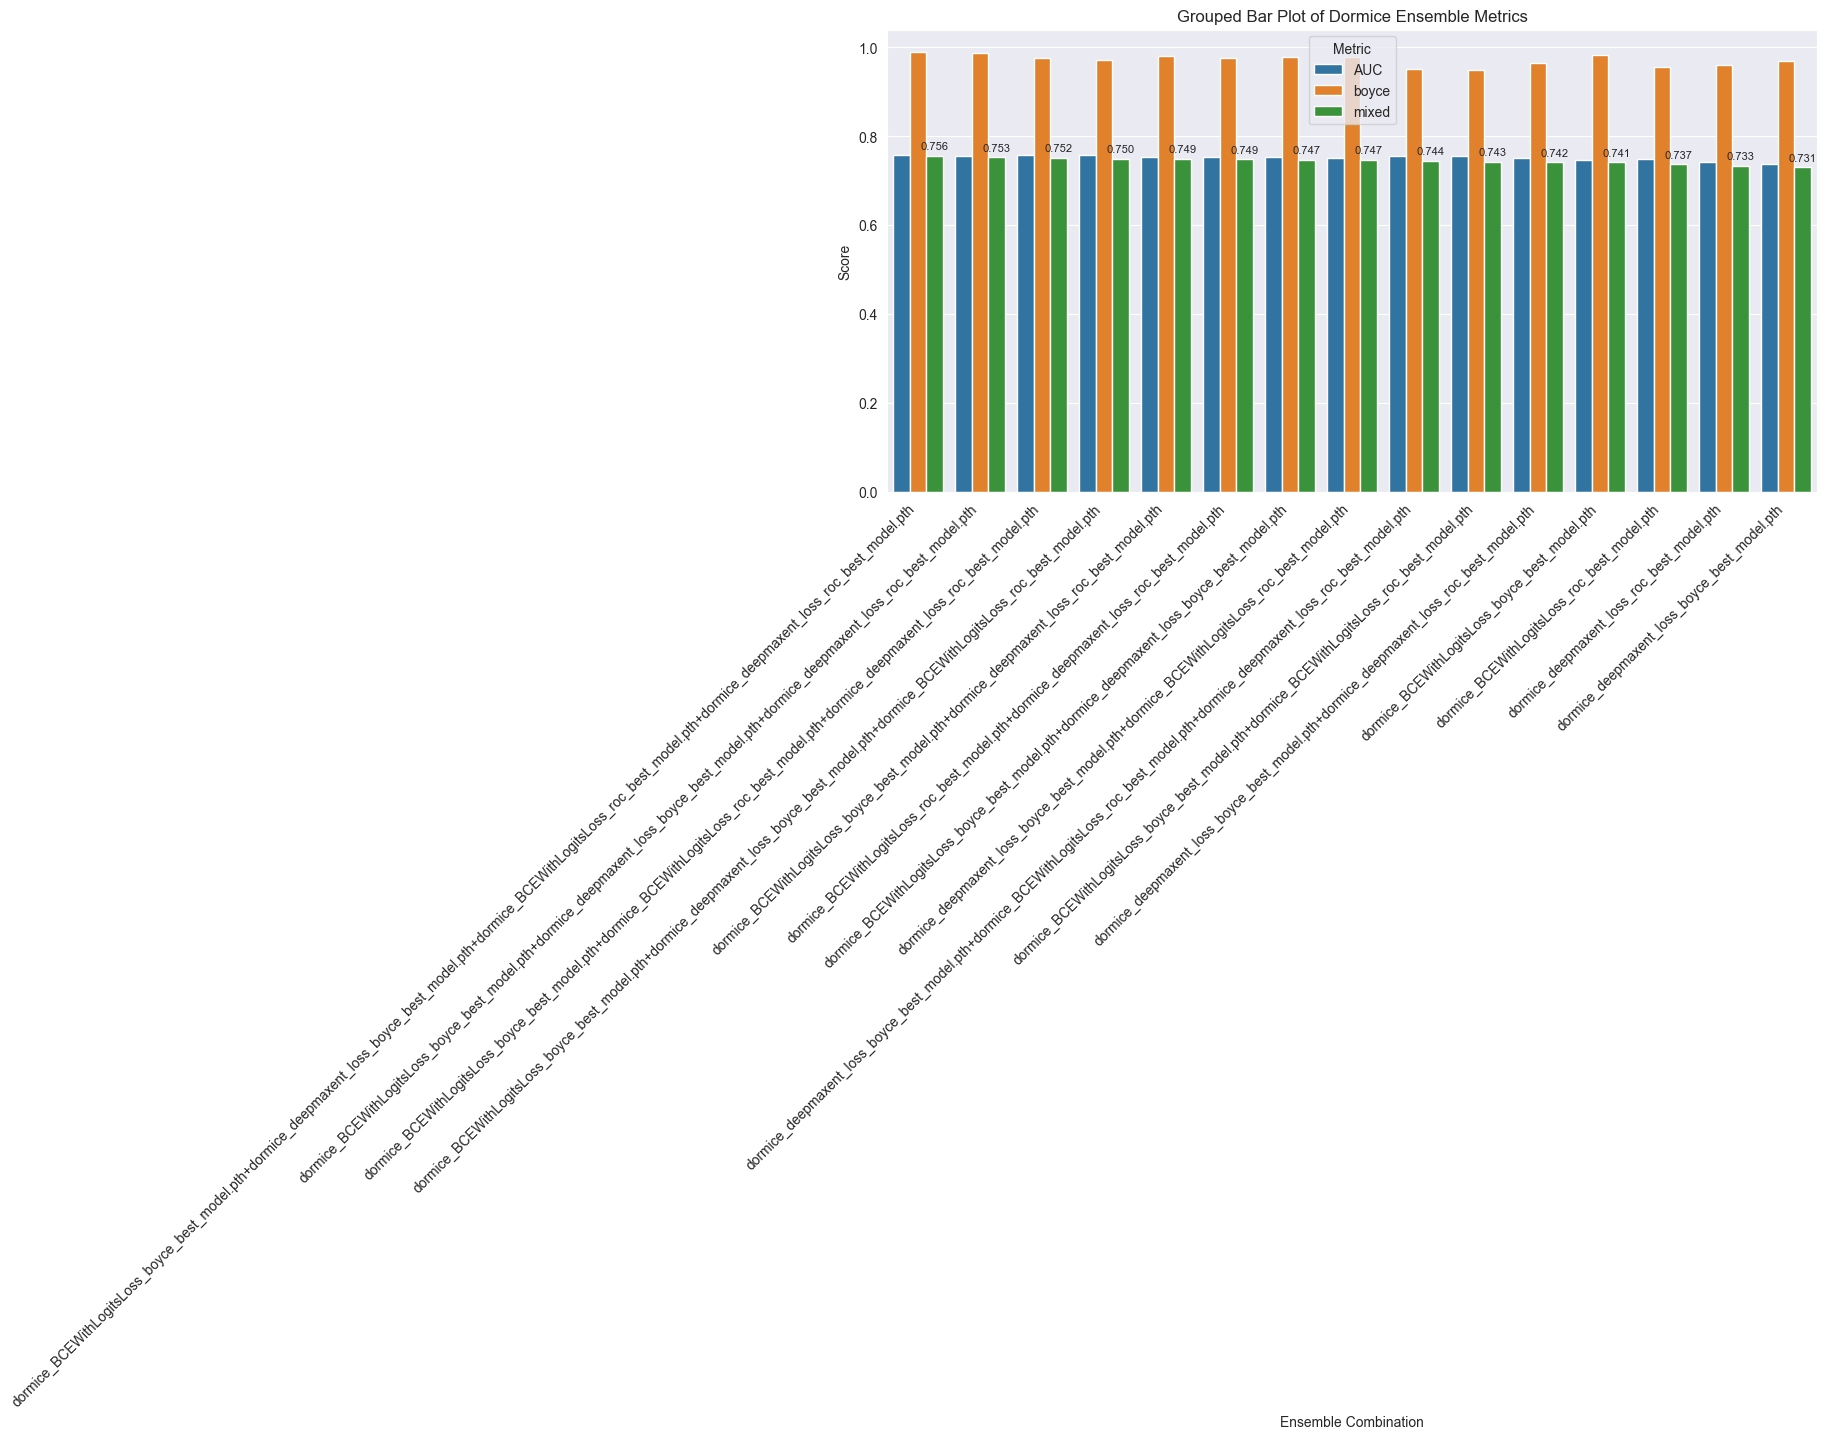

In [37]:
from itertools import chain, combinations
import numpy as np

dormice_models = [ "dormice_BCEWithLogitsLoss_boyce_best_model.pth", "dormice_deepmaxent_loss_boyce_best_model.pth", "dormice_BCEWithLogitsLoss_roc_best_model.pth", "dormice_deepmaxent_loss_roc_best_model.pth" ]

# Function to get the power set of a list
def powerset(iterable):
    "powerset([1,2,3]) --> [1] [2] [3] [1,2] [1,3] [2,3] [1,2,3]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# Evaluate an ensemble of models (average probabilities)
def evaluate_ensemble(models_list, species):
    """
    models_list: list of paths to saved model .pth files
    Returns: dict with roc, boyce, mixed
    """
    # Load dataset + scaler + test split (same as evaluate_model)
    df = pd.read_csv(f"{species}_final_data_preprocessed.csv")
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
    
    # Load split indices
    with open(f"{species}_split.pkl", "rb") as f:
        split_data = pickle.load(f)
    test_idx = split_data["test_idx"]
    
    # Load scaler
    scaler = pickle.load(open(f"{species}_scaler.pkl", "rb"))
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    
    # Prepare test set
    X_df = df.drop(columns=['type','label'])
    X_df[env_vars] = scaler.transform(X_df[env_vars])
    X_test_df = X_df.loc[test_idx]
    y_test_df = df.loc[test_idx, 'label']
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)
    
    # Store predictions from all models
    all_probs = []
    input_dim = X_test_tensor.shape[1]
    
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_test_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
    # Average probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    y_true = y_test_tensor.cpu().numpy().ravel()
    
    # Metrics
    try:
        roc = roc_auc_score(y_true, ensemble_probs)
    except ValueError:
        roc = 0.0
    boyce = boyce_index(ensemble_probs, y_true)
    roc_normalized = (roc - 0.5) / 0.5
    boyce_normalized = (boyce + 1) / 2
    mixed = (roc_normalized + boyce_normalized)/2
    
    return {"AUC": roc, "boyce": boyce, "mixed": mixed}


results = {}

for subset in powerset(dormice_models):
    # Ensemble name = full filenames joined by '+'
    subset_name = "+".join(subset)
    metrics = evaluate_ensemble(list(subset), species="dormice")
    results[subset_name] = metrics

# Convert to DataFrame and sort by mixed score
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("mixed", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for plotting
plot_df = results_df.reset_index().rename(columns={"index":"Ensemble"}).sort_values("mixed", ascending=False)
plot_df_melted = plot_df.melt(id_vars="Ensemble", var_name="Metric", value_name="Score")

# -----------------------------
# Grouped bar plot
# -----------------------------
plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df_melted, x="Ensemble", y="Score", hue="Metric")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ensemble Combination")
plt.ylabel("Score")
plt.title("Grouped Bar Plot of Dormice Ensemble Metrics")
plt.legend(title="Metric")
plt.tight_layout()

# -----------------------------
# Annotate only the Mixed bars
# -----------------------------
# The hue order in seaborn is usually alphabetical unless specified
# We'll get the unique metrics in the order Seaborn used
hue_order = sorted(plot_df_melted['Metric'].unique())
num_hues = len(hue_order)
num_ensembles = plot_df.shape[0]
total_width = 0.8
bar_width = total_width / num_hues

# Loop over each ensemble
for i in range(num_ensembles):
    x = i  # center of the group
    # Find mixed height
    mixed_height = plot_df_melted[
        (plot_df_melted['Ensemble'] == plot_df['Ensemble'].iloc[i]) & 
        (plot_df_melted['Metric'] == 'mixed')
    ]['Score'].values[0]
    # Compute x-position of the mixed bar (last bar in group)
    mixed_x = x - total_width/2 + bar_width*2 + bar_width/2
    ax.text(mixed_x, mixed_height + 0.01, f"{mixed_height:.3f}", ha='center', va='bottom', fontsize=8)

plt.show()



Loading and preprocessing data...
Data processing complete. Found 35 features.


  0%|          | 0/200 [00:00<?, ?it/s]


--- Top 15 Most Important Features ---
                           feature  importance
0                              LST   12.137134
1                             SAVI    0.642735
2                             NDSI    0.548766
3                            MNDWI    0.487076
4                              BSI    0.455957
5                             NDVI    0.328656
6              Land_cover_Suburban    0.319948
7                               UI    0.312966
8                             NDBI    0.268210
9                Land_cover_Arable    0.194135
10   Land_cover_Deciduous woodland    0.143783
11   Land_cover_Improved grassland    0.078572
12  Land_cover_Coniferous woodland    0.039550
13                            NDWI    0.037694
14            honeysuckle_presence    0.036765


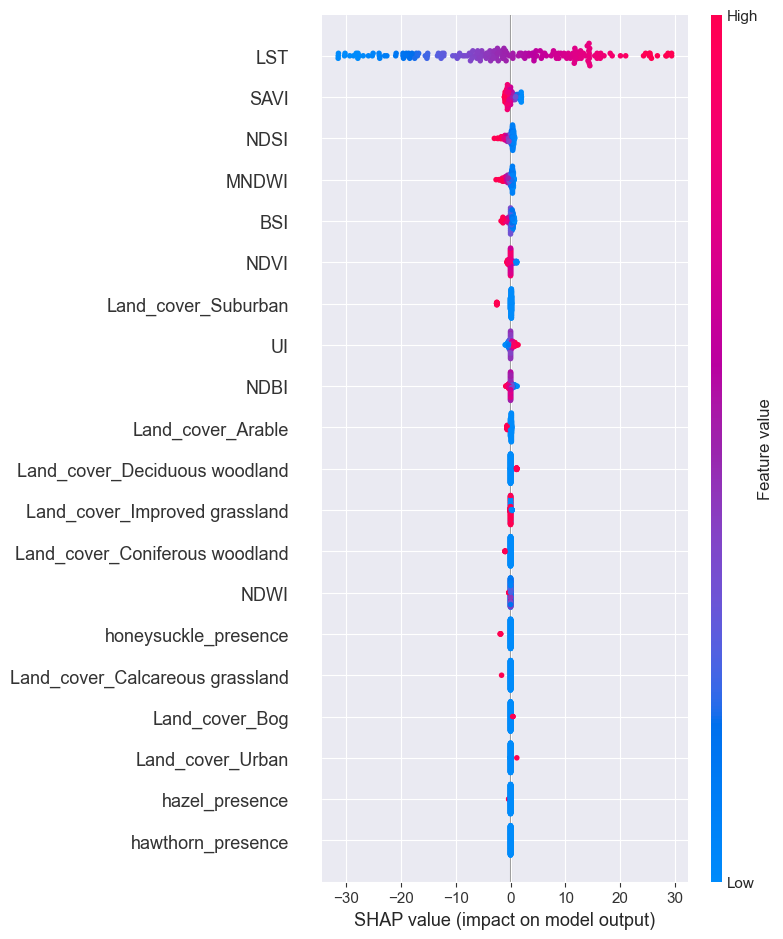

In [46]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ============================
# 1. PyTorch Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    """Residual MLP for Species Distribution Modeling"""
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)  # raw logits

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# 2. Data Loading and Preprocessing
# ============================
print("Loading and preprocessing data...")
df = pd.read_csv("dormice_final_data_preprocessed.csv")

# --- Preprocessing: map 'type' to binary if present
if 'type' in df.columns:
    df['presence'] = df['type'].map({'presence': 1, 'background': 0}).astype(int)
    df = df.drop(columns=['type'])

TARGET_COLUMN = 'presence'

# Convert boolean columns to integer
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

# Separate features and target
features_df = df.drop(columns=[TARGET_COLUMN])
target_series = df[TARGET_COLUMN]

X = features_df.values
feature_names = features_df.columns.tolist()
input_dim = X.shape[1]

print(f"Data processing complete. Found {input_dim} features.")

# ============================
# 3. Define Ensemble
# ============================
models_list = [
    "dormice_BCEWithLogitsLoss_boyce_best_model.pth", "dormice_deepmaxent_loss_boyce_best_model.pth", "dormice_BCEWithLogitsLoss_roc_best_model.pth", "dormice_deepmaxent_loss_roc_best_model.pth"
]

def ensemble_predict(X_input):
    """Return average raw logits across all models"""
    X_tensor = torch.tensor(X_input, dtype=torch.float32)
    all_logits = []
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            logits = model.forward(X_tensor).cpu().numpy().ravel()
            all_logits.append(logits)
    return np.mean(all_logits, axis=0)

# ============================
# 4. SHAP KernelExplainer
# ============================
background = X[np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)]
explainer = shap.KernelExplainer(ensemble_predict, background)

subset = X[:200]  # subset for speed
shap_values = explainer.shap_values(subset)
shap_values_array = np.array(shap_values)
shap_values_array = np.squeeze(shap_values_array)  # shape: (n_samples, n_features)

# ============================
# 5. Mean Absolute SHAP / Feature Importance
# ============================
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Most Important Features ---")
print(importance_df.head(15))

# ============================
# 6. Optional Barplot
# ============================
# Uncomment to visualize top 20 features
# plt.figure(figsize=(12, 10))
# sns.barplot(
#     x='importance',
#     y='feature',
#     data=importance_df.head(20),
#     palette='viridis'
# )
# plt.xlabel('Mean |SHAP Value|', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.title('Ensemble Feature Importance (KernelExplainer)', fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# ============================
# 7. SHAP Summary Plot
# ============================
subset_df = pd.DataFrame(subset, columns=feature_names)
top_features = importance_df['feature'].head(20).tolist()
subset_top = subset_df[top_features]
shap_values_top = shap_values_array[:, [feature_names.index(f) for f in top_features]]

shap.summary_plot(
    shap_values_top,
    subset_top,
    plot_type="dot",
    max_display=20
)


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71741/3493437622.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


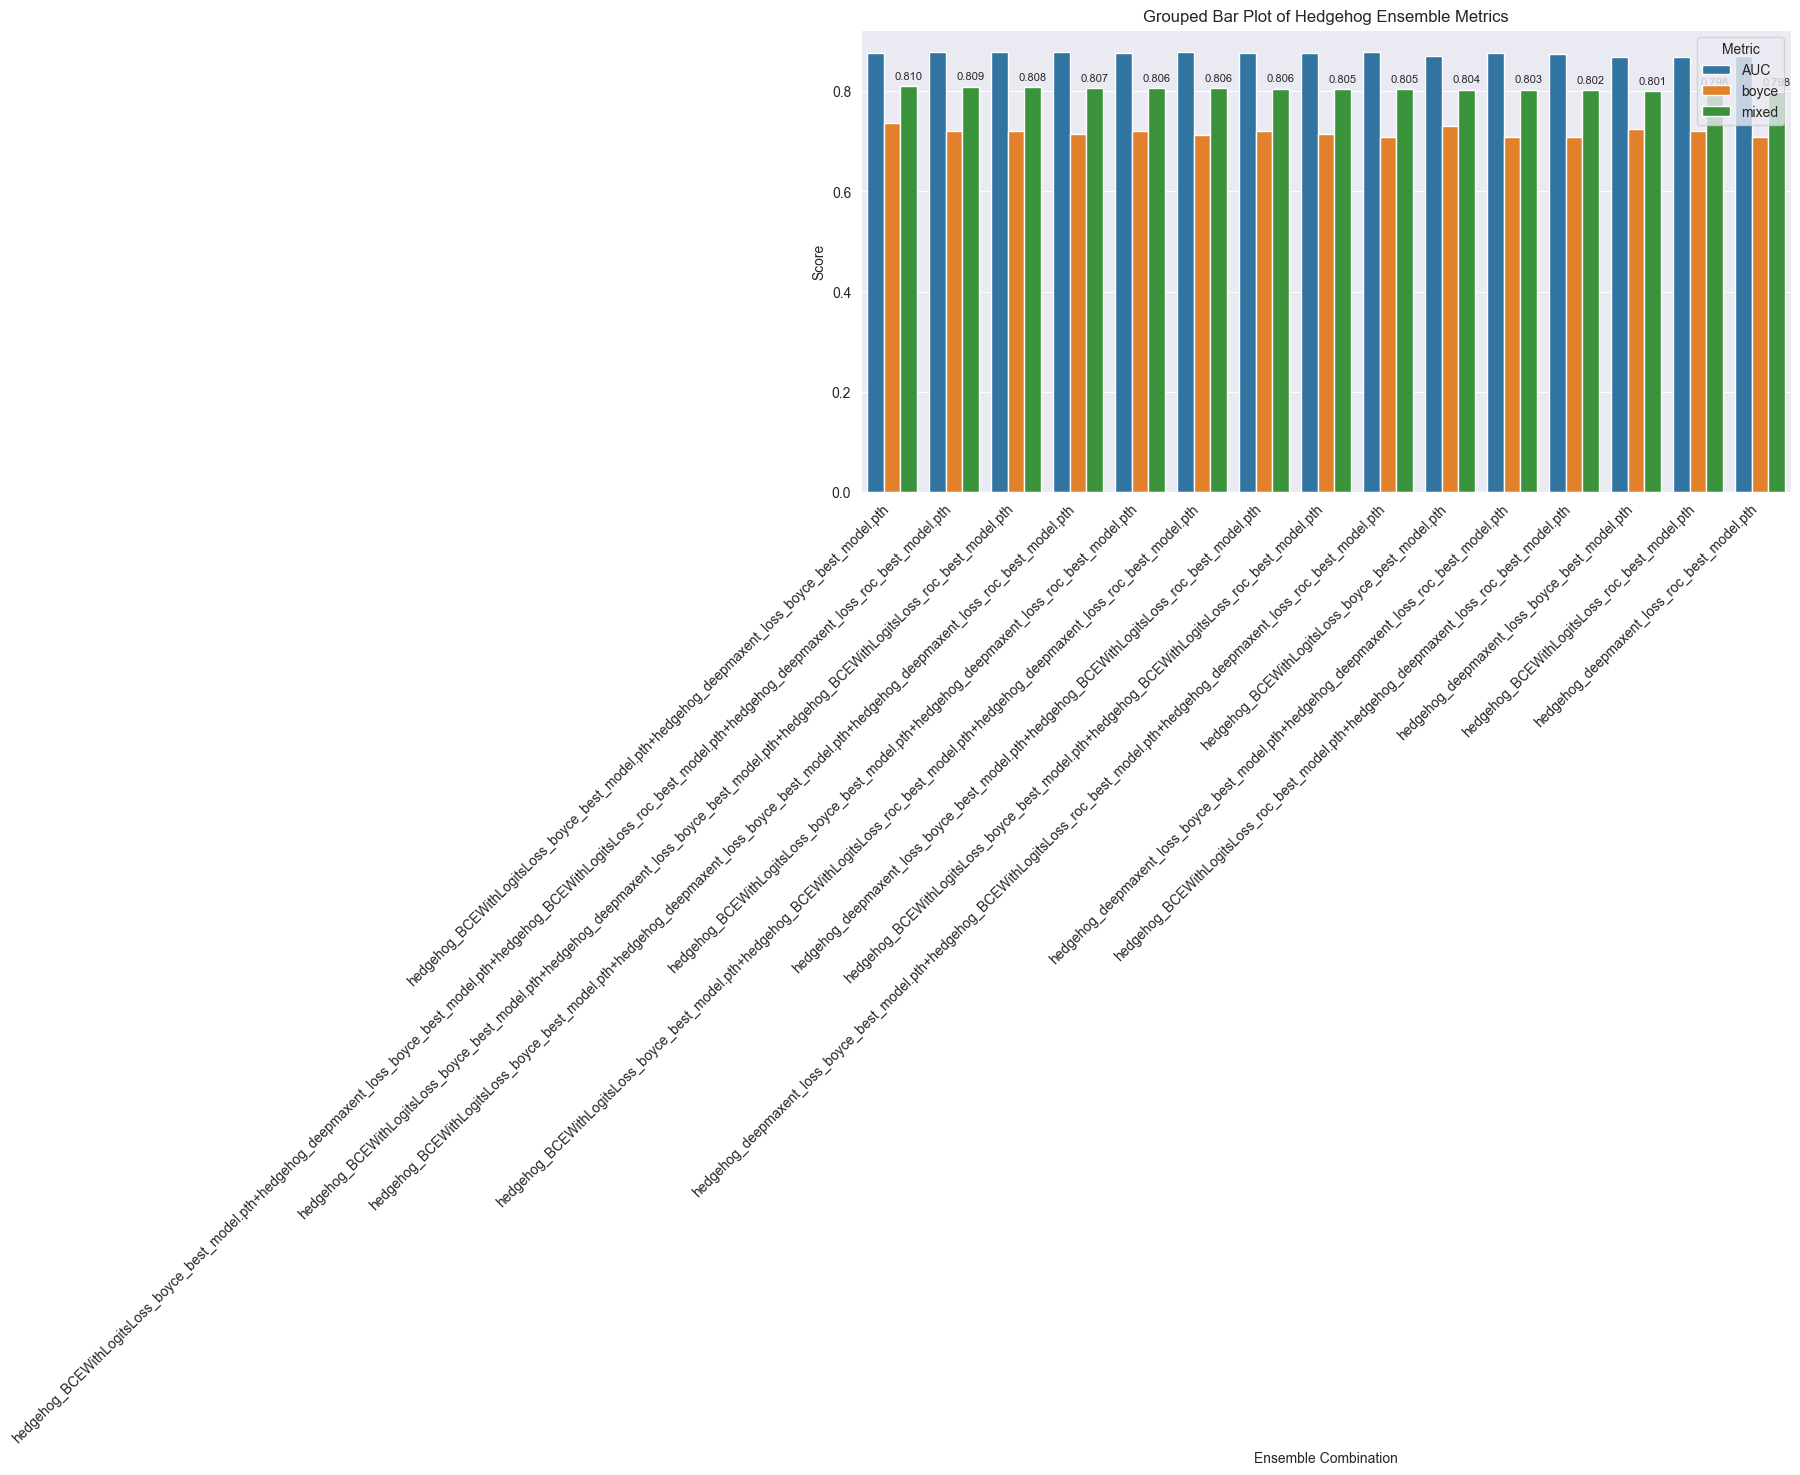

In [38]:
from itertools import chain, combinations
import numpy as np

hedgehog_models = [ "hedgehog_BCEWithLogitsLoss_boyce_best_model.pth", "hedgehog_deepmaxent_loss_boyce_best_model.pth", "hedgehog_BCEWithLogitsLoss_roc_best_model.pth", "hedgehog_deepmaxent_loss_roc_best_model.pth" ]

# Function to get the power set of a list
def powerset(iterable):
    "powerset([1,2,3]) --> [1] [2] [3] [1,2] [1,3] [2,3] [1,2,3]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# Evaluate an ensemble of models (average probabilities)
def evaluate_ensemble(models_list, species):
    """
    models_list: list of paths to saved model .pth files
    Returns: dict with roc, boyce, mixed
    """
    # Load dataset + scaler + test split (same as evaluate_model)
    df = pd.read_csv(f"{species}_final_data_preprocessed.csv")
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
    
    # Load split indices
    with open(f"{species}_split.pkl", "rb") as f:
        split_data = pickle.load(f)
    test_idx = split_data["test_idx"]
    
    # Load scaler
    scaler = pickle.load(open(f"{species}_scaler.pkl", "rb"))
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    
    # Prepare test set
    X_df = df.drop(columns=['type','label'])
    X_df[env_vars] = scaler.transform(X_df[env_vars])
    X_test_df = X_df.loc[test_idx]
    y_test_df = df.loc[test_idx, 'label']
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)
    
    # Store predictions from all models
    all_probs = []
    input_dim = X_test_tensor.shape[1]
    
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_test_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
    # Average probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    y_true = y_test_tensor.cpu().numpy().ravel()
    
    # Metrics
    try:
        roc = roc_auc_score(y_true, ensemble_probs)
    except ValueError:
        roc = 0.0
    boyce = boyce_index(ensemble_probs, y_true)
    roc_normalized = (roc - 0.5) / 0.5
    boyce_normalized = (boyce + 1) / 2
    mixed = (roc_normalized + boyce_normalized)/2
    
    return {"AUC": roc, "boyce": boyce, "mixed": mixed}


results = {}

for subset in powerset(hedgehog_models):
    # Ensemble name = full filenames joined by '+'
    subset_name = "+".join(subset)
    metrics = evaluate_ensemble(list(subset), species="hedgehog")
    results[subset_name] = metrics

# Convert to DataFrame and sort by mixed score
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("mixed", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for plotting
plot_df = results_df.reset_index().rename(columns={"index":"Ensemble"}).sort_values("mixed", ascending=False)
plot_df_melted = plot_df.melt(id_vars="Ensemble", var_name="Metric", value_name="Score")

# -----------------------------
# Grouped bar plot
# -----------------------------
plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df_melted, x="Ensemble", y="Score", hue="Metric")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ensemble Combination")
plt.ylabel("Score")
plt.title("Grouped Bar Plot of Hedgehog Ensemble Metrics")
plt.legend(title="Metric")
plt.tight_layout()

# -----------------------------
# Annotate only the Mixed bars
# -----------------------------
# The hue order in seaborn is usually alphabetical unless specified
# We'll get the unique metrics in the order Seaborn used
hue_order = sorted(plot_df_melted['Metric'].unique())
num_hues = len(hue_order)
num_ensembles = plot_df.shape[0]
total_width = 0.8
bar_width = total_width / num_hues

# Loop over each ensemble
for i in range(num_ensembles):
    x = i  # center of the group
    # Find mixed height
    mixed_height = plot_df_melted[
        (plot_df_melted['Ensemble'] == plot_df['Ensemble'].iloc[i]) & 
        (plot_df_melted['Metric'] == 'mixed')
    ]['Score'].values[0]
    # Compute x-position of the mixed bar (last bar in group)
    mixed_x = x - total_width/2 + bar_width*2 + bar_width/2
    ax.text(mixed_x, mixed_height + 0.01, f"{mixed_height:.3f}", ha='center', va='bottom', fontsize=8)

plt.show()



Loading and preprocessing data...
Data processing complete. Found 33 features.


  0%|          | 0/200 [00:00<?, ?it/s]


--- Top 15 Most Important Features ---
                          feature  importance
0                             LST   14.212447
1             Land_cover_Suburban    0.846035
2                             BSI    0.631052
3   Land_cover_Improved grassland    0.515979
4                            SAVI    0.512346
5                 badger_presence    0.409099
6                            NDVI    0.283642
7                            NDSI    0.240301
8                           MNDWI    0.228918
9                            NDWI    0.213581
10              Land_cover_Arable    0.144153
11                      near_road    0.118960
12                           NDBI    0.070388
13      Land_cover_Acid grassland    0.069369
14                             UI    0.052669


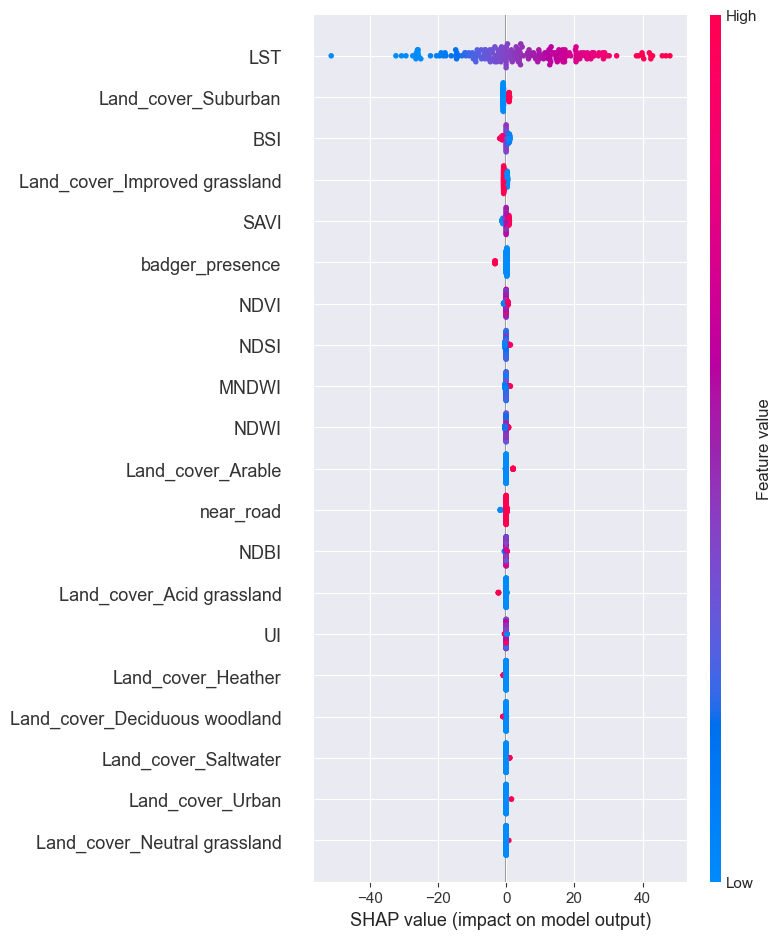

In [47]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ============================
# 1. PyTorch Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    """Residual MLP for Species Distribution Modeling"""
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)  # raw logits

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# 2. Data Loading and Preprocessing
# ============================
print("Loading and preprocessing data...")
df = pd.read_csv("hedgehog_final_data_preprocessed.csv")

# --- Preprocessing: map 'type' to binary if present
if 'type' in df.columns:
    df['presence'] = df['type'].map({'presence': 1, 'background': 0}).astype(int)
    df = df.drop(columns=['type'])

TARGET_COLUMN = 'presence'

# Convert boolean columns to integer
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

# Separate features and target
features_df = df.drop(columns=[TARGET_COLUMN])
target_series = df[TARGET_COLUMN]

X = features_df.values
feature_names = features_df.columns.tolist()
input_dim = X.shape[1]

print(f"Data processing complete. Found {input_dim} features.")

# ============================
# 3. Define Ensemble
# ============================
models_list = [
    "hedgehog_deepmaxent_loss_boyce_best_model.pth", "hedgehog_BCEWithLogitsLoss_boyce_best_model.pth"
]

def ensemble_predict(X_input):
    """Return average raw logits across all models"""
    X_tensor = torch.tensor(X_input, dtype=torch.float32)
    all_logits = []
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            logits = model.forward(X_tensor).cpu().numpy().ravel()
            all_logits.append(logits)
    return np.mean(all_logits, axis=0)

# ============================
# 4. SHAP KernelExplainer
# ============================
background = X[np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)]
explainer = shap.KernelExplainer(ensemble_predict, background)

subset = X[:200]  # subset for speed
shap_values = explainer.shap_values(subset)
shap_values_array = np.array(shap_values)
shap_values_array = np.squeeze(shap_values_array)  # shape: (n_samples, n_features)

# ============================
# 5. Mean Absolute SHAP / Feature Importance
# ============================
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Most Important Features ---")
print(importance_df.head(15))

# ============================
# 6. Optional Barplot
# ============================
# Uncomment to visualize top 20 features
# plt.figure(figsize=(12, 10))
# sns.barplot(
#     x='importance',
#     y='feature',
#     data=importance_df.head(20),
#     palette='viridis'
# )
# plt.xlabel('Mean |SHAP Value|', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.title('Ensemble Feature Importance (KernelExplainer)', fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# ============================
# 7. SHAP Summary Plot
# ============================
subset_df = pd.DataFrame(subset, columns=feature_names)
top_features = importance_df['feature'].head(20).tolist()
subset_top = subset_df[top_features]
shap_values_top = shap_values_array[:, [feature_names.index(f) for f in top_features]]

shap.summary_plot(
    shap_values_top,
    subset_top,
    plot_type="dot",
    max_display=20
)


/var/folders/0n/sggn66691kd6g5mtyzpq2hv80000gn/T/ipykernel_71741/3419219803.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


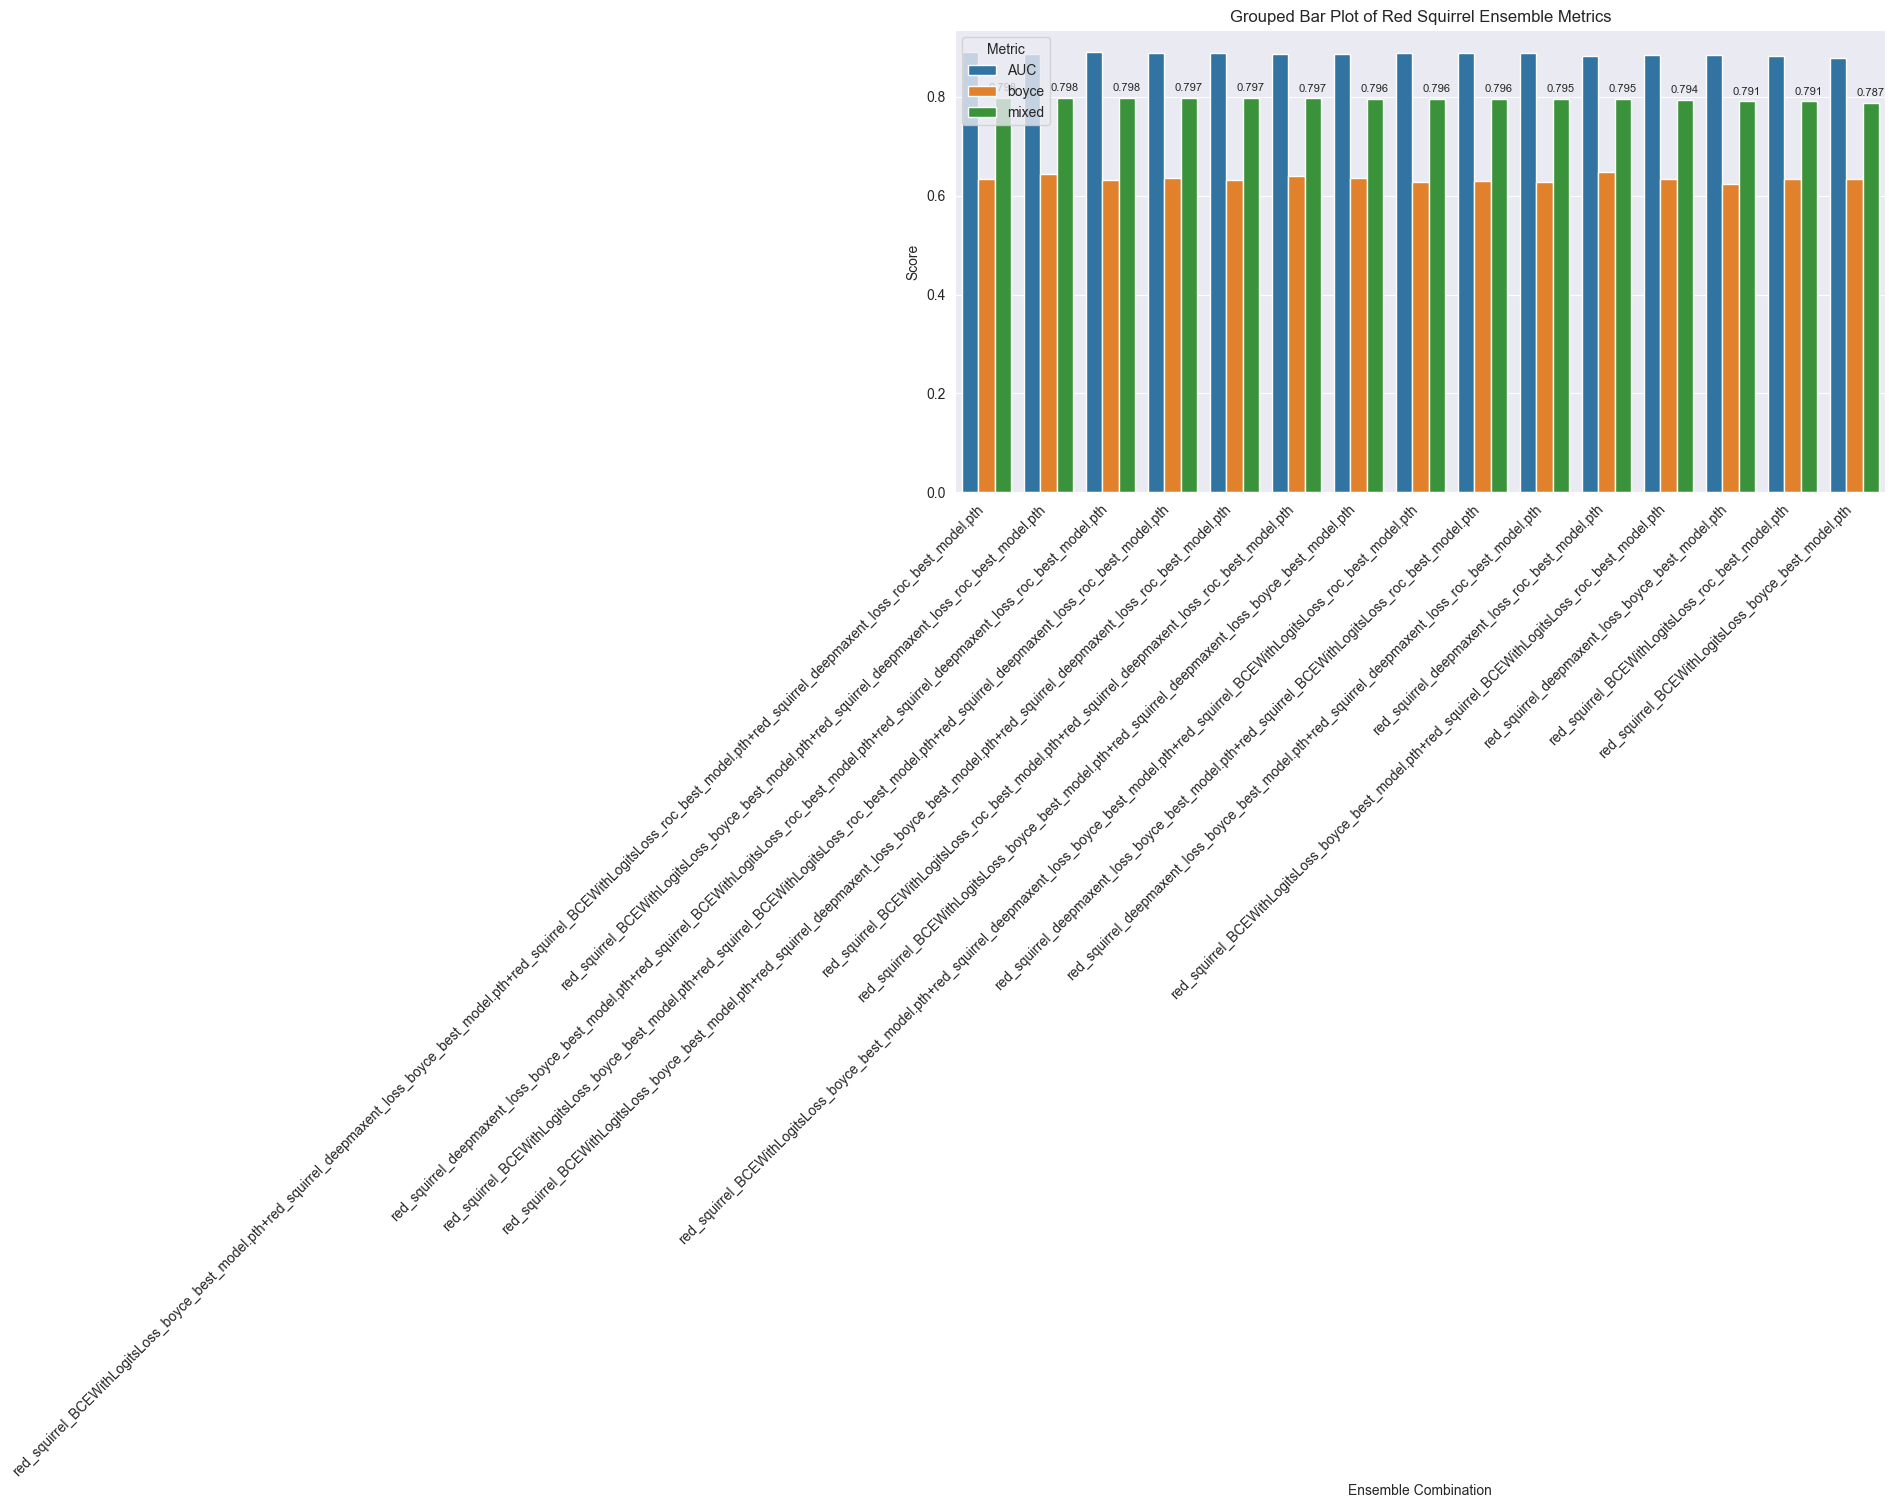

In [39]:
from itertools import chain, combinations
import numpy as np

red_squirrel_models = [ "red_squirrel_BCEWithLogitsLoss_boyce_best_model.pth", "red_squirrel_deepmaxent_loss_boyce_best_model.pth", "red_squirrel_BCEWithLogitsLoss_roc_best_model.pth", "red_squirrel_deepmaxent_loss_roc_best_model.pth" ]

# Function to get the power set of a list
def powerset(iterable):
    "powerset([1,2,3]) --> [1] [2] [3] [1,2] [1,3] [2,3] [1,2,3]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

# Evaluate an ensemble of models (average probabilities)
def evaluate_ensemble(models_list, species):
    """
    models_list: list of paths to saved model .pth files
    Returns: dict with roc, boyce, mixed
    """
    # Load dataset + scaler + test split (same as evaluate_model)
    df = pd.read_csv(f"{species}_final_data_preprocessed.csv")
    df['label'] = df['type'].map({'presence': 1, 'background': 0})
    df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
    
    # Load split indices
    with open(f"{species}_split.pkl", "rb") as f:
        split_data = pickle.load(f)
    test_idx = split_data["test_idx"]
    
    # Load scaler
    scaler = pickle.load(open(f"{species}_scaler.pkl", "rb"))
    env_vars = ['BSI', 'LST', 'MNDWI', 'NDBI', 'NDSI', 'NDVI', 'NDWI', 'SAVI', 'UI']
    
    # Prepare test set
    X_df = df.drop(columns=['type','label'])
    X_df[env_vars] = scaler.transform(X_df[env_vars])
    X_test_df = X_df.loc[test_idx]
    y_test_df = df.loc[test_idx, 'label']
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)
    
    # Store predictions from all models
    all_probs = []
    input_dim = X_test_tensor.shape[1]
    
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            probs = model.predict_proba(X_test_tensor).cpu().numpy().ravel()
            all_probs.append(probs)
    
    # Average probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    y_true = y_test_tensor.cpu().numpy().ravel()
    
    # Metrics
    try:
        roc = roc_auc_score(y_true, ensemble_probs)
    except ValueError:
        roc = 0.0
    boyce = boyce_index(ensemble_probs, y_true)
    roc_normalized = (roc - 0.5) / 0.5
    boyce_normalized = (boyce + 1) / 2
    mixed = (roc_normalized + boyce_normalized)/2
    
    return {"AUC": roc, "boyce": boyce, "mixed": mixed}


results = {}

for subset in powerset(red_squirrel_models):
    # Ensemble name = full filenames joined by '+'
    subset_name = "+".join(subset)
    metrics = evaluate_ensemble(list(subset), species="red_squirrel")
    results[subset_name] = metrics

# Convert to DataFrame and sort by mixed score
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("mixed", ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for plotting
plot_df = results_df.reset_index().rename(columns={"index":"Ensemble"}).sort_values("mixed", ascending=False)
plot_df_melted = plot_df.melt(id_vars="Ensemble", var_name="Metric", value_name="Score")

# -----------------------------
# Grouped bar plot
# -----------------------------
plt.figure(figsize=(12,6))
ax = sns.barplot(data=plot_df_melted, x="Ensemble", y="Score", hue="Metric")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Ensemble Combination")
plt.ylabel("Score")
plt.title("Grouped Bar Plot of Red Squirrel Ensemble Metrics")
plt.legend(title="Metric")
plt.tight_layout()

# -----------------------------
# Annotate only the Mixed bars
# -----------------------------
# The hue order in seaborn is usually alphabetical unless specified
# We'll get the unique metrics in the order Seaborn used
hue_order = sorted(plot_df_melted['Metric'].unique())
num_hues = len(hue_order)
num_ensembles = plot_df.shape[0]
total_width = 0.8
bar_width = total_width / num_hues

# Loop over each ensemble
for i in range(num_ensembles):
    x = i  # center of the group
    # Find mixed height
    mixed_height = plot_df_melted[
        (plot_df_melted['Ensemble'] == plot_df['Ensemble'].iloc[i]) & 
        (plot_df_melted['Metric'] == 'mixed')
    ]['Score'].values[0]
    # Compute x-position of the mixed bar (last bar in group)
    mixed_x = x - total_width/2 + bar_width*2 + bar_width/2
    ax.text(mixed_x, mixed_height + 0.01, f"{mixed_height:.3f}", ha='center', va='bottom', fontsize=8)

plt.show()



Loading and preprocessing data...
Data processing complete. Found 32 features.


  0%|          | 0/200 [00:00<?, ?it/s]


--- Top 15 Most Important Features ---
                           feature  importance
0                              LST   31.501099
1                              BSI    3.393542
2    Land_cover_Improved grassland    2.060457
3                            MNDWI    1.749483
4                             NDSI    1.708412
5                             NDWI    1.534552
6    Land_cover_Deciduous woodland    0.610704
7   Land_cover_Coniferous woodland    0.480869
8                             SAVI    0.338819
9                               UI    0.288941
10                            NDBI    0.281221
11          grey_squirrel_presence    0.206998
12       Land_cover_Acid grassland    0.131451
13                            NDVI    0.103780
14             Land_cover_Suburban    0.076581


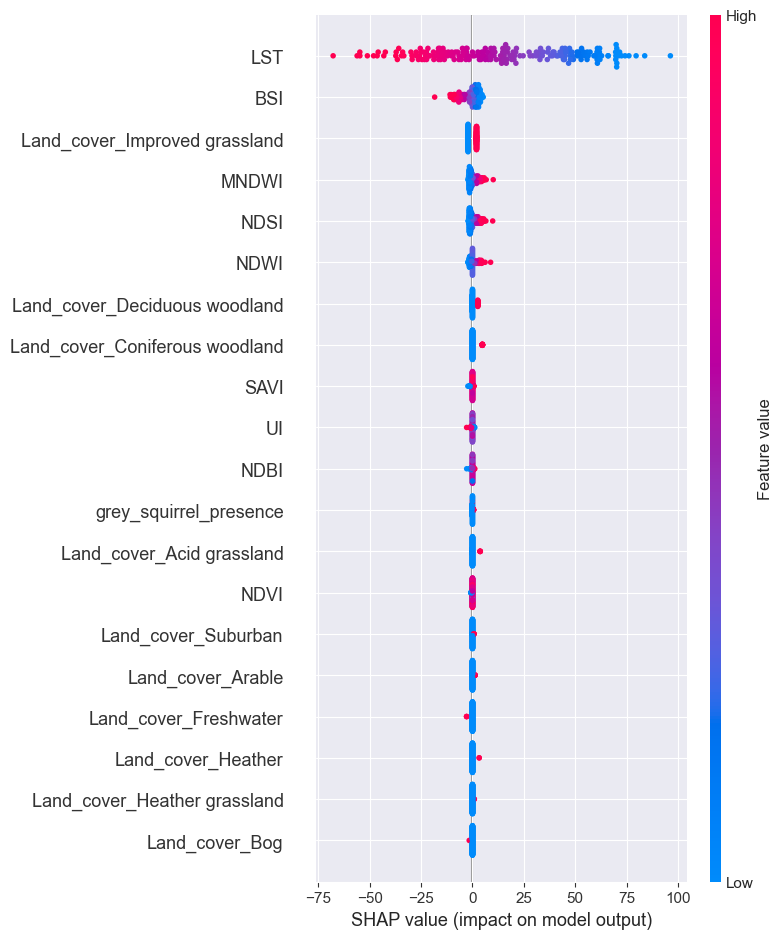

In [48]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ============================
# 1. PyTorch Model Definition
# ============================
class DeepMaxEntModel(nn.Module):
    """Residual MLP for Species Distribution Modeling"""
    def __init__(self, input_dim, hidden_dim=250, num_hidden_layers=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            residual = x
            out = layer(x)
            out = self.activation(out)
            x = out + residual
        return self.output_layer(x)  # raw logits

    def predict_proba(self, x):
        return torch.sigmoid(self.forward(x))

# ============================
# 2. Data Loading and Preprocessing
# ============================
print("Loading and preprocessing data...")
df = pd.read_csv("red_squirrel_final_data_preprocessed.csv")

# --- Preprocessing: map 'type' to binary if present
if 'type' in df.columns:
    df['presence'] = df['type'].map({'presence': 1, 'background': 0}).astype(int)
    df = df.drop(columns=['type'])

TARGET_COLUMN = 'presence'

# Convert boolean columns to integer
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

# Separate features and target
features_df = df.drop(columns=[TARGET_COLUMN])
target_series = df[TARGET_COLUMN]

X = features_df.values
feature_names = features_df.columns.tolist()
input_dim = X.shape[1]

print(f"Data processing complete. Found {input_dim} features.")

# ============================
# 3. Define Ensemble
# ============================
models_list = [
    "red_squirrel_BCEWithLogitsLoss_boyce_best_model.pth", "red_squirrel_BCEWithLogitsLoss_roc_best_model.pth", "red_squirrel_deepmaxent_loss_roc_best_model.pth","red_squirrel_deepmaxent_loss_boyce_best_model.pth"
]

def ensemble_predict(X_input):
    """Return average raw logits across all models"""
    X_tensor = torch.tensor(X_input, dtype=torch.float32)
    all_logits = []
    for model_path in models_list:
        model = DeepMaxEntModel(input_dim=input_dim)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            logits = model.forward(X_tensor).cpu().numpy().ravel()
            all_logits.append(logits)
    return np.mean(all_logits, axis=0)

# ============================
# 4. SHAP KernelExplainer
# ============================
background = X[np.random.choice(X.shape[0], min(50, X.shape[0]), replace=False)]
explainer = shap.KernelExplainer(ensemble_predict, background)

subset = X[:200]  # subset for speed
shap_values = explainer.shap_values(subset)
shap_values_array = np.array(shap_values)
shap_values_array = np.squeeze(shap_values_array)  # shape: (n_samples, n_features)

# ============================
# 5. Mean Absolute SHAP / Feature Importance
# ============================
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n--- Top 15 Most Important Features ---")
print(importance_df.head(15))

# ============================
# 6. Optional Barplot
# ============================
# Uncomment to visualize top 20 features
# plt.figure(figsize=(12, 10))
# sns.barplot(
#     x='importance',
#     y='feature',
#     data=importance_df.head(20),
#     palette='viridis'
# )
# plt.xlabel('Mean |SHAP Value|', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.title('Ensemble Feature Importance (KernelExplainer)', fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# ============================
# 7. SHAP Summary Plot
# ============================
subset_df = pd.DataFrame(subset, columns=feature_names)
top_features = importance_df['feature'].head(20).tolist()
subset_top = subset_df[top_features]
shap_values_top = shap_values_array[:, [feature_names.index(f) for f in top_features]]

shap.summary_plot(
    shap_values_top,
    subset_top,
    plot_type="dot",
    max_display=20
)
